In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [16]:
from CNN_LSTM import VisualCNN

In [17]:
X_rays = np.load('../data/CNN_LSTM/updated_rays.npy')  # (N, T, R)
Y_pos =  np.load('../data/CNN_LSTM/updated_pos.npy')    # (N, T, 2)
Y_vel =  np.load('../data/CNN_LSTM/updated_vel.npy')    # (N, 2)
print("X_rays shape:", X_rays.shape)
print("Y_pos shape:", Y_pos.shape)
print("Y_vel shape:", Y_vel.shape)

Y_pos_final = Y_pos[:, -1, :]  # position at last time step

X_rays shape: (73763, 5, 107)
Y_pos shape: (73763, 5, 2)
Y_vel shape: (73763, 2)


In [ ]:
# === Flatten dataset for frame-level training ===
# X_flat = X_rays.reshape(-1, X_rays.shape[2])           # (N*T, R)
# Y_flat = Y_pos.reshape(-1, Y_pos.shape[2]) # (N*T, 2)

X_tensor = torch.tensor(X_rays[:, -1, :], dtype=torch.float32)   # (N*T, R)
Y_tensor = torch.tensor(Y_pos_final, dtype=torch.float32)   # (N*T, 2)

dataset = TensorDataset(X_tensor, Y_tensor)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)
loader = DataLoader(TensorDataset(torch.tensor(X_rays_test[:, -1, :], dtype=torch.float32), torch.tensor(Y_pos_test[:, -1,:], dtype=torch.float32)), batch_size=2, shuffle=True)

# === Build model ===
model = VisualCNN(num_rays=X_rays.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Train loop ===
losses = []
for epoch in range(50):
    epoch_loss = 0
    for xb, yb in loader:
        pred = model(xb)               # xb: (B, R)
        loss = criterion(pred, yb)     # yb: (B, 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")


# X_tensor = torch.tensor(X_rays, dtype=torch.float32)
# Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
# Y_target = torch.tensor(np.concatenate([Y_pos_final, Y_vel], axis=1), dtype=torch.float32)

# dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_target)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# model = GatedFusionModel(num_rays=X_rays.shape[2])
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# losses = []
# for epoch in range(50):
#     epoch_loss = 0
#     for xb_rays, xb_pos, yb in loader:
#         pred = model(xb_rays, xb_pos)
#         loss = criterion(pred, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     avg_loss = epoch_loss / len(loader)
#     losses.append(avg_loss)
#     print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

Epoch 0: Loss = 0.2699
Epoch 1: Loss = 0.1969
Epoch 2: Loss = 0.1776
Epoch 3: Loss = 0.1694
Epoch 4: Loss = 0.1693
Epoch 5: Loss = 0.1615
Epoch 6: Loss = 0.1617
Epoch 7: Loss = 0.1514
Epoch 8: Loss = 0.1526
Epoch 9: Loss = 0.1486
Epoch 10: Loss = 0.1456
Epoch 11: Loss = 0.1430
Epoch 12: Loss = 0.1422
Epoch 13: Loss = 0.1397
Epoch 14: Loss = 0.1394
Epoch 15: Loss = 0.1370
Epoch 16: Loss = 0.1346
Epoch 17: Loss = 0.1346
Epoch 18: Loss = 0.1322
Epoch 19: Loss = 0.1332
Epoch 20: Loss = 0.1309
Epoch 21: Loss = 0.1310
Epoch 22: Loss = 0.1302
Epoch 23: Loss = 0.1309
Epoch 24: Loss = 0.1287
Epoch 25: Loss = 0.1276
Epoch 26: Loss = 0.1325
Epoch 27: Loss = 0.1282
Epoch 28: Loss = 0.1274
Epoch 29: Loss = 0.1275
Epoch 30: Loss = 0.1286
Epoch 31: Loss = 0.1264
Epoch 32: Loss = 0.1278
Epoch 33: Loss = 0.1258
Epoch 34: Loss = 0.1263
Epoch 35: Loss = 0.1249
Epoch 36: Loss = 0.1273
Epoch 37: Loss = 0.1266
Epoch 38: Loss = 0.1251
Epoch 39: Loss = 0.1262
Epoch 40: Loss = 0.1250
Epoch 41: Loss = 0.1257
Ep

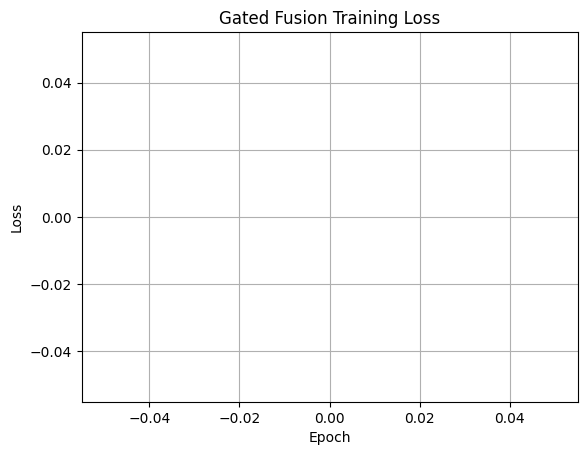

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Gated Fusion Training Loss")
plt.grid(True)
plt.show()

In [ ]:
X_rays_test = np.load('../data/CNN_LSTM_test_rays.npy')  # (N, T, R)
Y_pos_test =  np.load('../data/CNN_LSTM_test_pos.npy')    # (N, T, 2)
print("X_rays_test shape:", X_rays_test.shape)
print("Y_pos_test shape:", Y_pos_test.shape)

Y_pos_final_test = Y_pos_test[:, -1, :]  # position at last time step
print("Y_pos_final_test shape:", Y_pos_final_test.shape)

X_rays_test shape: (4701, 5, 107)
Y_pos_test shape: (4701, 5, 2)
Y_pos_final_test shape: (4701, 2)


In [ ]:
model.eval()
with torch.no_grad():
    i = np.random.randint(0, len(X_rays_test))
    test_ray = torch.tensor(X_rays_test[i:i+1], dtype=torch.float32)
    test_pos = torch.tensor(Y_pos_test[i:i+1], dtype=torch.float32)
    # print("Test ray shape:", Y_pos_test[i:i+1].shape)
    # prediction = model(test_ray, torch.zeros((1,5,2))).numpy()[0]
    prediction = model(test_ray).numpy()[0]

    print("Predicted (x, y, vx, vy):", prediction)
    print("Ground truth (x, y, vx, vy):", np.concatenate([Y_pos_final_test[i], Y_vel_test[i]]))


c:\Users\griff\anaconda3\envs\vision\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (2) at non-singleton dimension 1

In [13]:
X_tensor = torch.tensor(X_rays, dtype=torch.float32)  # (N, T, R)
Y_target = torch.tensor(np.concatenate([Y_pos_final], axis=1), dtype=torch.float32)  # (N, 4)

dataset = TensorDataset(X_tensor, Y_target)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# === Build model ===
model = GatedFusionModel(num_rays=X_rays.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Train loop ===
losses = []
for epoch in range(50):
    epoch_loss = 0
    for xb_rays, yb in loader:
        # pred = model(xb_rays) 
        # loss = criterion(pred, yb)
        prediction = model(xb_rays)
        pred = prediction[:, :4]  # position only
        cnn_pos = prediction[:, 4:]
        # pred, cnn_pos = model(xb_rays)
        loss_main = criterion(pred, yb)
        loss_cnn = criterion(cnn_pos, yb[:, :2])  # position only
        loss = loss_main + 0.3 * loss_cnn  # weighted training (try to make the CNN learn position)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

# X_tensor = torch.tensor(X_rays, dtype=torch.float32)
# Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
# Y_target = torch.tensor(np.concatenate([Y_pos_final, Y_vel], axis=1), dtype=torch.float32)

# dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_target)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# model = GatedFusionModel(num_rays=X_rays.shape[2])
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# losses = []
# for epoch in range(50):
#     epoch_loss = 0
#     for xb_rays, xb_pos, yb in loader:
#         pred = model(xb_rays, xb_pos)
#         loss = criterion(pred, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     avg_loss = epoch_loss / len(loader)
#     losses.append(avg_loss)
#     print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

NameError: name 'GatedFusionModel' is not defined

In [24]:
class RayTransformer(nn.Module):
    def __init__(self, num_rays, d_model=64, nhead=4):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output x, z
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (B, R) → (B, R, 1)
        x = self.input_proj(x)  # (B, R, d_model)
        x = self.transformer(x)  # (B, R, d_model)
        x = x.mean(dim=1)  # Mean pool over rays
        return self.fc(x)

In [ ]:
# === Flatten dataset for frame-level training ===
# X_flat = X_rays.reshape(-1, X_rays.shape[2])           # (N*T, R)
# Y_flat = Y_pos.reshape(-1, Y_pos.shape[2]) # (N*T, 2)

X_tensor = torch.tensor(X_rays[:, -1, :], dtype=torch.float32)   # (N*T, R)
Y_tensor = torch.tensor(Y_pos_final, dtype=torch.float32)   # (N*T, 2)

ray_mean = X_tensor.mean()
ray_std = X_tensor.std()
X_tensor = (X_tensor - ray_mean) / ray_std

target_mean = Y_tensor.mean(0)
target_std = Y_tensor.std(0)
Y_norm = (Y_tensor - target_mean) / target_std

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# === Build model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RayTransformer(num_rays=107).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Train loop ===
losses = []
for epoch in range(50):
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")